In [1]:
# Basic SciPy packages
import numpy as np
import pandas as pd

# Stats Packages
from scipy import stats

# Graphing packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
# %matplotlib tk

#Load my random dataset
import CreateDataSet

## Generate Dataset

In [2]:
#cvd_dataset = CreateDataSet.make_cvd_dataset()

In [3]:
## Save dataset to csv to lock it in. 
# cvd_dataset.to_csv("CVD_Dataset_EDA_ANOVA.csv", index = False)
cvd_dataset = pd.read_csv("CVD_Dataset_EDA_ANOVA.csv")
cvd_dataset 

,RunID,Power,GrowthRate
0,1,8,5002.320019
1,2,8,5003.601457
2,3,8,5001.024675
3,4,8,5001.576370
4,1,10,5070.505941
5,2,10,5053.803062
6,3,10,5050.102792
7,4,10,5050.176954
8,1,12,5110.123564
9,2,12,5100.022294


## EDA

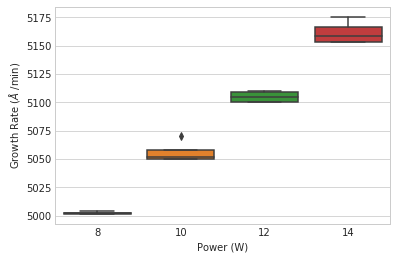

In [4]:
## Create a box plot with updated labels. 
boxplot_for_CVD = sns.boxplot(x = "Power", y = "GrowthRate", data = cvd_dataset)
plt.xlabel(r"Power (W)")
plt.ylabel(r"Growth Rate ($\AA$ /min)")

plt.savefig('boxplot_for_CVD.png')

In [5]:
## Create my own ANOVA - save this set for residuals further on.
cvd_dataset_initial = cvd_dataset

In [6]:
cvd_dataset_initial

,RunID,Power,GrowthRate
0,1,8,5002.320019
1,2,8,5003.601457
2,3,8,5001.024675
3,4,8,5001.576370
4,1,10,5070.505941
5,2,10,5053.803062
6,3,10,5050.102792
7,4,10,5050.176954
8,1,12,5110.123564
9,2,12,5100.022294


## Arrange data for analysis

In [7]:
cvd_pivot = cvd_dataset.pivot(index = 'RunID', columns = 'Power', values = 'GrowthRate')
cvd_pivot

Power,8,10,12,14
RunID,,,,
1,5002.320019,5070.505941,5110.123564,5163.853637
2,5003.601457,5053.803062,5100.022294,5153.563207
3,5001.024675,5050.102792,5108.673395,5175.444188
4,5001.576370,5050.176954,5100.200780,5153.171650


## Compute DFs, Sums, MSs, and F-Value

In [8]:
def degrees_of_freedom(df_pivot):
    ## Between samples is across the row
    ## Within samples is down the column
    n = df_pivot.count(axis=1) # Define number of replicates within treatment
    a = df_pivot.count() # Determine number of treatments
    n = n.iloc[0]
    a = a.iloc[0]
    
    TotalN = n*a # Total number of datapoint
    dft = a - 1 #dft is degrees of freedom between sample set
    dfe = TotalN - a #dfe is degrees of freedom within samples
    dftotal = TotalN-1 #dftotal is degrees of freedom total 
    return dft, dfe, dftotal, n, a 

In [9]:
dft, dfe, dftotal, n, a = degrees_of_freedom(cvd_pivot)

print("Degrees of freedom between treatments: {:d}".format(dft))
print("Degrees of freedom within treatments: {:d}".format(dfe))
print("Total degrees of freedom: {:d}".format(dftotal))

Degrees of freedom between treatments: 3
Degrees of freedom within treatments: 12
Total degrees of freedom: 15


In [10]:
def compute_sums(df_pivot):
    yi_sum = df_pivot.sum() # Compute sum under i-th treatment
    yi_avg = df_pivot.mean() # Compute average under i-th treatment 
    y_sum = yi_sum.sum() # Compute grand sum
    y_avg = yi_avg.mean() # Compute grand average
    return yi_sum, yi_avg, y_sum, y_avg

In [11]:
yi_sum, yi_avg, y_sum, y_avg = compute_sums(cvd_pivot) #retrieve respective sums 

print(r"The sum under each Power (W) treatment is: {}".format(yi_sum))
print(r"The average under each Power (W) treatment is: {}".format(yi_avg))
print(r"The grand sum is: {:.2f}".format(y_sum))
print(r"The grand average is: {:.2f}".format(y_avg))

The sum under each Power (W) treatment is: Power
8     20008.522520
10    20224.588749
12    20419.020034
14    20646.032682
dtype: float64
The average under each Power (W) treatment is: Power
8     5002.130630
10    5056.147187
12    5104.755008
14    5161.508171
dtype: float64
The grand sum is: 81298.16
The grand average is: 5081.14


In [12]:
def Sum_of_Squares(yi_avg, y_avg, df_pivot):
    SSTR = (yi_avg - y_avg)**2 #Calculate sum of squares between treatments
    SSTR = SSTR.sum()*n
    SSE = df_pivot.sub(yi_avg.values) ** 2 #Calculate sum of squares within treatments
    SSE = SSE.sum().sum()
    SST = SSTR + SSE # Total corrected sum of squares
    return SSTR, SSE, SST

In [13]:
SSTR, SSE, SST = Sum_of_Squares(yi_avg,y_avg, cvd_pivot)
print("Sum of Squares between treatments is: {:.2f}".format(SSTR))
print("Sum of Squares within treatments is: {:.2f}".format(SSE))
print("Total Sum of Squares is: {:.2f}".format(SST))

Sum of Squares between treatments is: 55535.33
Sum of Squares within treatments is: 707.23
Total Sum of Squares is: 56242.56


In [14]:
def Mean_Squares(SSTR, SSE, dft, dfe):
    MSTR = SSTR/(dft) ## Mean Square between Treatments
    MSE = SSE/(dfe) ## Mean Square Error (within)
    return MSTR, MSE

In [15]:
MSTR, MSE = Mean_Squares(SSTR, SSE, dft, dfe)

print("Mean squares between treatments is: {:.2f}".format(MSTR))
print("Mean squares within treatments is: {:.2f}".format(MSE))

Mean squares between treatments is: 18511.78
Mean squares within treatments is: 58.94


In [16]:
F = MSTR/MSE #F-value
p = stats.f.sf(F, dft, dfe)

print("F-value is: {:.2f}".format(F))
print("p-value is: {:.3f}".format(p))

F-value is: 314.10
p-value is: 0.000


## Effect sizes

In [17]:
eta_sqr = SSTR/SST
eta_sqr

0.98742544312564173

In [18]:
ome_sqr = (SSTR - (a*MSE))/ (SST+ n)
ome_sqr

0.98316400102902102

## Check versus Built-in

In [19]:
#Check versus built in
from scipy import stats

f_val, p_val = stats.f_oneway(cvd_pivot[8], cvd_pivot[10], cvd_pivot[12], cvd_pivot[14])  
print("F-value is: {:.2f}".format(f_val))
print("p-value is: {:.3f}".format(p_val))

F-value is: 314.10
p-value is: 0.000


## Create Model

In [20]:
## Point estimator of mu_i is mu_hat plus ti hat which is yi_bar
## Mu hat is also y hat
mu_hat = yi_avg
mu_hat

Power
8     5002.130630
10    5056.147187
12    5104.755008
14    5161.508171
dtype: float64

In [22]:
##Determine treatment effects
t_hat = mu_hat - y_avg

## Compute Residuals

In [23]:
cvd_pivot_residuals = cvd_pivot.sub(mu_hat, axis = 1)

In [24]:
cvd_pivot_residuals

Power,8,10,12,14
RunID,,,,
1,0.189389,14.358754,5.368556,2.345466
2,1.470827,-2.344125,-4.732715,-7.944964
3,-1.105955,-6.044396,3.918387,13.936017
4,-0.554260,-5.970233,-4.554228,-8.336520


In [25]:
# Melt back to plot
cvd_pivot_residuals_melted = cvd_pivot_residuals.melt()
cvd_pivot_residuals_melted

,Power,value
0,8,0.189389
1,8,1.470827
2,8,-1.105955
3,8,-0.554260
4,10,14.358754
5,10,-2.344125
6,10,-6.044396
7,10,-5.970233
8,12,5.368556
9,12,-4.732715


((array([-1.72352605, -1.26569652, -0.97848645, -0.75533862, -0.56472935,
         -0.39279634, -0.23181469, -0.07666006,  0.07666006,  0.23181469,
          0.39279634,  0.56472935,  0.75533862,  0.97848645,  1.26569652,
          1.72352605]),
  array([ -8.33652014,  -7.94496357,  -6.04439566,  -5.97023305,
          -4.73271453,  -4.55422813,  -2.34412509,  -1.10595532,
          -0.55426038,   0.18938883,   1.47082687,   2.34546622,
           3.91838677,   5.36855589,  13.9360175 ,  14.3587538 ])),
 (6.9679028437325536, -5.8019446278472391e-16, 0.95434159239334748))

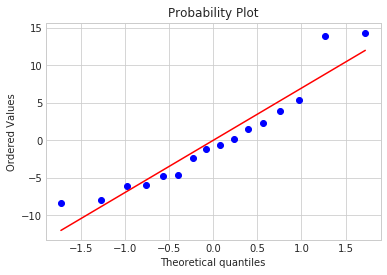

In [26]:
stats.probplot(cvd_pivot_residuals_melted['value'], plot=plt)

#-> Looks good

In [27]:
cvd_predict_residual = cvd_pivot_residuals_melted

In [28]:
for power_setting, power_avg in mu_hat.iteritems():
    cvd_predict_residual.loc[cvd_predict_residual['Power'] == power_setting, 'Power'] =\
    power_avg

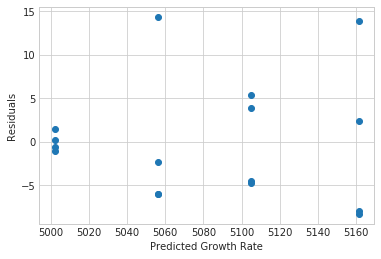

In [29]:
plt.scatter(cvd_predict_residual['Power'], cvd_predict_residual['value'])
plt.xlabel('Predicted Growth Rate')
plt.ylabel('Residuals')
plt.show()

## Check for Outliers

In [30]:
def check_outliers(residuals, mean_square_error):
    check_out = residuals.iloc[:,1:].divide(mean_square_error ** (0.5))
    return check_out[abs(check_out) > 1]
     

In [31]:
check_outliers(cvd_pivot_residuals_melted, MSE)

,value
0,NaN
1,NaN
2,NaN
3,NaN
4,1.870374
5,NaN
6,NaN
7,NaN
8,NaN
9,NaN


In [32]:
## No significant outliers. Needed to be > 2

## Fit a Regression Model

In [36]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [39]:
model_set = cvd_dataset[['Power', 'GrowthRate']]
model_set

,Power,GrowthRate
0,8,5002.320019
1,8,5003.601457
2,8,5001.024675
3,8,5001.576370
4,10,5070.505941
5,10,5053.803062
6,10,5050.102792
7,10,5050.176954
8,12,5110.123564
9,12,5100.022294


In [55]:
Power_X = model_set['Power']
Power_X = Power_X.as_matrix().reshape(-1, 1)

Power_X

array([[ 8],
       [ 8],
       [ 8],
       [ 8],
       [10],
       [10],
       [10],
       [10],
       [12],
       [12],
       [12],
       [12],
       [14],
       [14],
       [14],
       [14]])

In [56]:
Growth_Y = model_set['GrowthRate']
Growth_Y = Growth_Y.as_matrix().reshape(-1, 1)

In [58]:
regr = linear_model.LinearRegression()

In [59]:
Growth_Y

array([[ 5002.32001887],
       [ 5003.60145691],
       [ 5001.02467472],
       [ 5001.57636966],
       [ 5070.50594117],
       [ 5053.80306227],
       [ 5050.1027917 ],
       [ 5050.17695432],
       [ 5110.12356435],
       [ 5100.02229393],
       [ 5108.67339523],
       [ 5100.20078033],
       [ 5163.85363675],
       [ 5153.56320696],
       [ 5175.44418803],
       [ 5153.17165039]])

In [60]:
regr.fit(Power_X, Growth_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [62]:
regr.coef_

array([[ 26.33702213]])

In [63]:
## Need to split up into test and train sets

In [ ]:
## Operating Curves